# SHEAR BUILDING: Modal Analysis and Matrix Definition of a Multi-Story Structure

This notebook performs the modal analysis of a multi-story shear building. It defines the stiffness, mass, and damping matrices, and computes the natural frequencies, mode shapes, and effective modal masses. Finally, it visualizes the mode shapes.

---
## Author and Usage Notice

**Author:** Humberto Brambila de Salles, Dr.

- This work is provided for educational and academic purposes.  
- You are welcome to use, adapt, and build upon the code, provided that proper credit is given to the author.  
- If you use this code or refer to the methodology in publications, presentations, or projects, please cite it as follows:

> Brambila de Salles, H. (2025). Modal Analysis of Multi-Story Shear Buildings — Code and Notebook. Available at: [GitHub URL]

- For questions or collaborations, please contact: [humberto.salles@hotmail.com]

Thank you for respecting the academic and intellectual property rights associated with this work.

---
**How to use:**  
- Run the cells sequentially from top to bottom using `Ctrl+Enter`.
- To edit a cell, simply click it.
- You can also run all cells at once via **Run → Run All Cells**.
- If you modify the code, remember to **restart the kernel and clear all outputs** before rerunning.

Enjoy your analysis! 🚀

## IMPORTING LIBRARIES AND FUNCTION DEFINITIONS

In [1]:
# Import
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh

Matplotlib is building the font cache; this may take a moment.


In [2]:
# Generates the stiffness matrix for a multi-story shear building model
def MultiStory_Stiffness(Ks, N):
    KK = Ks * np.ones(N + 1)
    KK[-1] = 0
    K = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            if i == j:
                K[i, j] = KK[i] + KK[i + 1]
            elif i == j + 1:
                K[i, j] = -KK[i]
            elif j == i + 1:
                K[i, j] = -KK[j]
    return K

## INPUTS [S.I. UNITS]

In [3]:
## General building parameters
story_number = 4                # Number of stories
h_story = 3                     # Story height (m)
E_story = 2.6e10                # Elastic modulus (Pa)
n_columns = 16                  # Number of columns per story
csi = 0.05                      # Damping ratio (5%)
n_modes_to_plot = story_number  # Number of mode shapes to plot (must be <= story_number)
# -----------------------------------------------------
## Cross-sectional dimensions (m)
b_columns, h_columns = 0.3, 0.3 # Column cross-section
b_beam, h_beam = 0.2, 0.5       # Beam cross-section
h_slab = 0.2                    # Slab thickness
# -----------------------------------------------------
## Mass per story (kg)
rho_concrete = 2500             # Density of concrete (kg/m³)
tot_lb = 144                    # Total length of beams per story (m)
tot_as = 18 * 18                # Total area of slabs per story (m²)
dead_load = 980.665             # Additional dead load (N/m²)
live_load = 1470.9975           # Live load (N/m²)
# Mass calculations
add_dead_load = dead_load / 9.80665  # Additional due to the dead load (kg/m²)
add_live_load = live_load / 9.80665  # Additional due to the live load (kg/m²)
M_beam = tot_lb * b_beam * h_beam * rho_concrete  # Mass of beams
M_column = n_columns * h_story * b_columns * h_columns * rho_concrete  # Mass of columns
M_slab = tot_as * (h_slab * rho_concrete + add_dead_load + 0.4 * add_live_load)  # Mass of slab (including loads)
M_story = M_beam + M_column + M_slab  # Total mass per story
print(f"Total mass per story: {M_story:.2f} kg")

Total mass per story: 260640.00 kg


## SHEAR BUILDING MATRICES - STIFFNESS AND MASS

In [4]:
## Stiffness Matrix Calculation
I_columns = (b_columns * (h_columns ** 3)) / 12                     # Moment of inertia of each column (m⁴)
K_story = n_columns * ((12 * E_story * I_columns) / (h_story ** 3)) # Lateral stiffness of a single story (N/m)
K = MultiStory_Stiffness(K_story, story_number)                     # Global stiffness matrix for the multi-story shear building
# -----------------------------------------------------
## Mass Matrix Calculation
M = M_story * np.eye(story_number)                                  # Lumped mass matrix assuming equal mass per story
M[-1, -1] -= M_column / 2                                           # Adjustment to account for half the column mass not contributing to the top floor

## MODAL ANALYSIS

In [5]:
## Solve generalized eigenvalue problem
# Solve [K]{phi} = w²[M]{phi}
w2, phi = eigh(K, M)                      # Eigenvalues (w²) and mode shapes (phi)
phi = np.real(phi)                        # Ensure real mode shapes
f_rad = np.sqrt(w2)                       # Natural frequencies (rad/s)
f_Hz = f_rad / (2 * np.pi)                # Natural frequencies (Hz)
# -----------------------------------------------------
## Mass Normalization of Mode Shapes
# Normalize each mode shape so that phiᵢᵀ·M·phiᵢ = 1
for i in range(story_number):
    phi[:, i] /= np.sqrt(phi[:, i].T @ M @ phi[:, i])
# -----------------------------------------------------
## Modal Participation Factors and Effective Modal Masses
unit_vector = np.ones((story_number, 1))  # Direction of excitation (all DOFs)
Gamma = phi.T @ M @ unit_vector           # Modal participation factors
M_eff = Gamma.flatten()**2                # Effective modal masses
M_total = np.sum(np.diag(M))              # Total mass of the system
M_eff_percent = 100 * M_eff / M_total     # Effective modal mass (in %)
# -----------------------------------------------------
## Cumulative Effective Modal Mass
cumulative_percent = np.cumsum(M_eff_percent)

## SHEAR BUILDING - DAMPING MATRIX

In [6]:
## Damping Matrix Using the First Two Modes (Rayleigh Damping)
# Rayleigh damping coefficients based on the first two natural frequencies
# C = α·M + β·K, where α and β are chosen to match a damping ratio (csi) for the first two modes
alpha = (2 * csi * f_rad[0] * f_rad[1]) / (f_rad[1] + f_rad[0])
beta = (2 * csi) / (f_rad[1] + f_rad[0])
# Damping matrix
C = alpha * M + beta * K

## PLOT MODE SHAPES OF THE SHEAR BUILDING

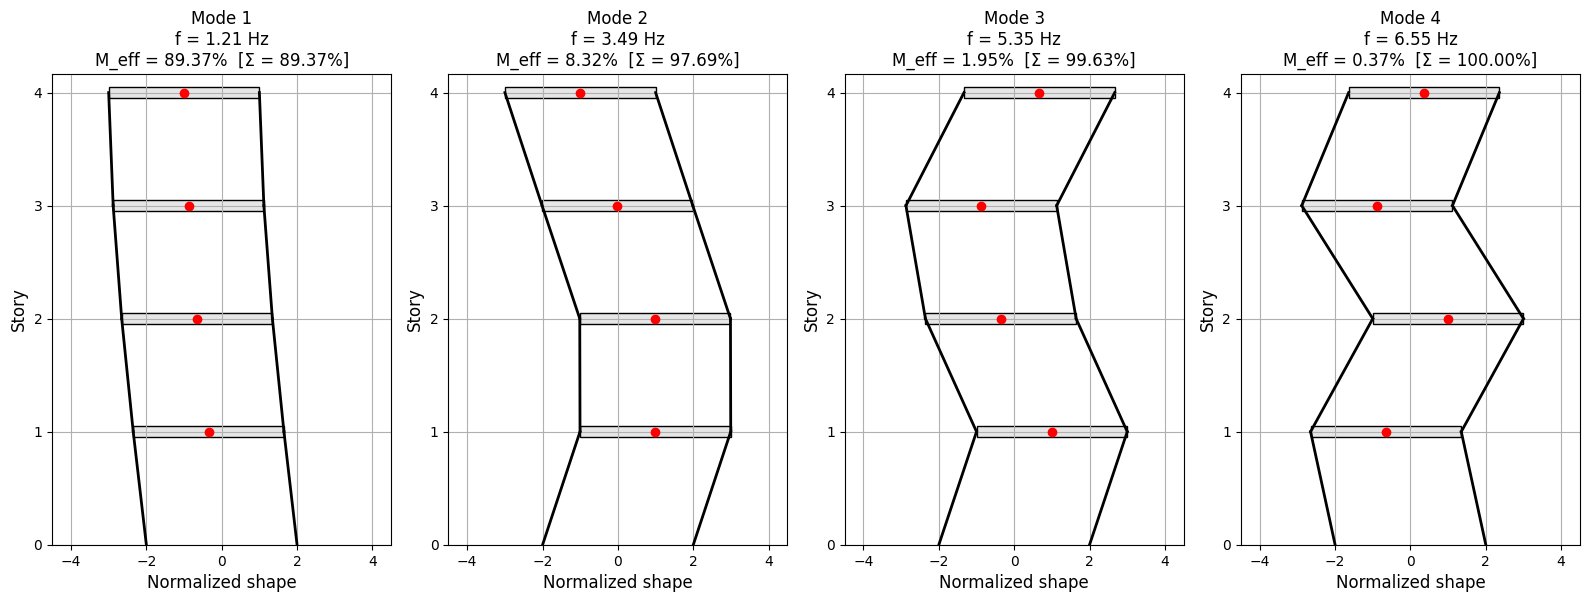

In [8]:
# Normalization of mode shapes by maximum absolute value per mode (for visualization)
phi_norm = phi / np.max(np.abs(phi), axis=0)

# Heights of each floor for plotting
floor_heights = np.arange(1, story_number + 1) * h_story

# Visual parameters for slab and columns
slab_fill_color = [0.9, 0.9, 0.9]
column_base_left = -2
column_base_right = 2
x_padding = 2.5

# Create side-by-side subplots for each mode shape
fig, axes = plt.subplots(1, n_modes_to_plot, figsize=(4 * n_modes_to_plot, 6))
if n_modes_to_plot == 1:
    axes = [axes]  # Ensure axes is iterable even if single plot

for i, ax in enumerate(axes):
    ax.set_aspect('equal')
    ax.grid(True)
    ax.set_xlim(column_base_left - x_padding, column_base_right + x_padding)
    ax.set_ylim(0, h_story * story_number + 0.5)
    
    ax.set_xlabel('Normalized modal amplitude',
        fontsize=12)
    ax.set_ylabel('Story',
        fontsize=12)
    
    # Y-axis ticks and labels for each floor (including ground = 0)
    ax.set_yticks(np.arange(0, h_story * (story_number + 1), h_story))
    ax.set_yticklabels([str(i) for i in range(story_number + 1)])

    # Plot columns and slabs, story by story
    for j in range(story_number):
        y_bot = j * h_story
        y_top = (j + 1) * h_story
        
        # Displacement at the bottom and top of the current story (zero for ground level)
        dx_bot = phi_norm[j - 1, i] if j > 0 else 0
        dx_top = phi_norm[j, i]

        # Calculate the lateral positions of the left and right columns at the bottom and top
        xL_bot = column_base_left + dx_bot
        xL_top = column_base_left + dx_top
        xR_bot = column_base_right + dx_bot
        xR_top = column_base_right + dx_top

        # Plot left and right columns
        ax.plot([xL_bot, xL_top], [y_bot, y_top], 'k', linewidth=2)
        ax.plot([xR_bot, xR_top], [y_bot, y_top], 'k', linewidth=2)

        # Plot slab as a filled rectangle connecting the columns at the top of the story
        slab_left = xL_top
        slab_right = xR_top
        y1 = y_top - 0.15
        y2 = y_top + 0.15
        ax.fill([slab_left, slab_right, slab_right, slab_left], [y1, y1, y2, y2],
                color=slab_fill_color, edgecolor='k')
        
        # Mark the slab center with a red dot
        slab_center = (slab_left + slab_right) / 2
        ax.plot(slab_center, y_top, 'ro', markerfacecolor='r')

    # Title with mode number, frequency, and effective modal mass (percentage and cumulative)
    ax.set_title(
        f"Mode {i+1}\n"
        f"f = {f_Hz[i]:.2f} Hz\n"
        f"M_eff = {M_eff_percent[i]:.2f}%  [Σ = {cumulative_percent[i]:.2f}%]",
        fontsize=12
    )

plt.tight_layout()
plt.show()